In [10]:
import warnings
from typing import Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import tempfile

warnings.filterwarnings("ignore")

In [11]:
batch_size = 4
seq_length = 512
n_hidden = 64
n_layers = 4
drop_prob = 0.1
lr = 0.1

In [12]:
with open(r"/home/an/Downloads/anek.txt", "r", encoding="utf-8") as f:
    text = f.read()

def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]

cut_text = cut_data(text)

In [13]:
def one_hot_encode(int_words: torch.Tensor, vocab_size: int) -> torch.Tensor:
    """Encodes batch of sentences into binary values."""
    batch_size, seq_len = int_words.shape
    device = int_words.device  
    words_one_hot = torch.zeros((batch_size, seq_len, vocab_size), device=device)
    int_words = int_words.long()

    for batch_idx in range(batch_size):
        words_one_hot[batch_idx, torch.arange(seq_len, device=device), int_words[batch_idx]] = 1.0
    
    return words_one_hot


In [14]:
with tempfile.NamedTemporaryFile(delete=False, mode="w", encoding="utf-8") as temp_file:
    temp_file.write(text)
    temp_file_path = temp_file.name


In [15]:
class Tokenizer:
    def __init__(self, text, vocab_size: int = 500):
        self.text = text
        self.vocab_size = vocab_size

        self.specials = {"<pad>": 1000, "<bos>": 1001, "<eos>": 1002}

        self.merges = self.init_merges(self.text.encode("utf-8"))

        self.vocab = {idx: bytes([idx]) for idx in range(256)}
        for (p0, p1), idx in self.merges.items():
            self.vocab[idx] = self.vocab[p0] + self.vocab[p1]

        self.vocab.update({idx: tok.encode("utf-8") for tok, idx in self.specials.items()})

        self.idx_to_vocab = {v: k for k, v in self.vocab.items()}

    def init_merges(self, tokens):
        tokens = list(map(int, tokens))
        merges = {}
        ids = list(tokens)
        num_merges = self.vocab_size - 256 - len(self.specials)  
        for i in range(num_merges):
            stats = self.get_stats(ids)
            if not stats:
                break
            pair = max(stats, key=stats.get)
            idx = 256 + len(self.specials) + i
            merges[pair] = idx
            ids = self.merge(ids, pair, idx)
        return merges

    def get_stats(self, ids):
        counts = {}
        for pair in zip(ids, ids[1:]):
            counts[pair] = counts.get(pair, 0) + 1
        return counts

    def merge(self, ids, pair, idx):
        newids = []
        i = 0
        while i < len(ids):
            if i < len(ids) - 1 and ids[i] == pair[0] and ids[i + 1] == pair[1]:
                newids.append(idx)
                i += 2
            else:
                newids.append(ids[i])
                i += 1
        return newids

    def decode_symbol(self, idx):
        char = self.vocab[idx]
        return char.decode("utf-8", errors="replace")
    
    def encode_symbol(self, el):
        return self.vocab[el]

    def encode(self, text):
        tokens = [self.specials["<bos>"]] + list(text.encode("utf-8")) + [self.specials["<eos>"]]
        while len(tokens) >= 2:
            stats = self.get_stats(tokens)
            pair = min(stats, key=lambda p: self.merges.get(p, float("inf")), default=None)
            if pair not in self.merges:
                break
            idx = self.merges[pair]
            tokens = self.merge(tokens, pair, idx)
        return tokens

    def decode(self, ids):
        tokens = b"".join(self.vocab[idx] for idx in ids if idx not in [self.specials["<bos>"], self.specials["<eos>"]])
        text = tokens.decode("utf-8", errors="replace")
        return text
    
tokenizer = Tokenizer(text)

print(tokenizer.vocab)
print(len(tokenizer.merges))

{0: b'\x00', 1: b'\x01', 2: b'\x02', 3: b'\x03', 4: b'\x04', 5: b'\x05', 6: b'\x06', 7: b'\x07', 8: b'\x08', 9: b'\t', 10: b'\n', 11: b'\x0b', 12: b'\x0c', 13: b'\r', 14: b'\x0e', 15: b'\x0f', 16: b'\x10', 17: b'\x11', 18: b'\x12', 19: b'\x13', 20: b'\x14', 21: b'\x15', 22: b'\x16', 23: b'\x17', 24: b'\x18', 25: b'\x19', 26: b'\x1a', 27: b'\x1b', 28: b'\x1c', 29: b'\x1d', 30: b'\x1e', 31: b'\x1f', 32: b' ', 33: b'!', 34: b'"', 35: b'#', 36: b'$', 37: b'%', 38: b'&', 39: b"'", 40: b'(', 41: b')', 42: b'*', 43: b'+', 44: b',', 45: b'-', 46: b'.', 47: b'/', 48: b'0', 49: b'1', 50: b'2', 51: b'3', 52: b'4', 53: b'5', 54: b'6', 55: b'7', 56: b'8', 57: b'9', 58: b':', 59: b';', 60: b'<', 61: b'=', 62: b'>', 63: b'?', 64: b'@', 65: b'A', 66: b'B', 67: b'C', 68: b'D', 69: b'E', 70: b'F', 71: b'G', 72: b'H', 73: b'I', 74: b'J', 75: b'K', 76: b'L', 77: b'M', 78: b'N', 79: b'O', 80: b'P', 81: b'Q', 82: b'R', 83: b'S', 84: b'T', 85: b'U', 86: b'V', 87: b'W', 88: b'X', 89: b'Y', 90: b'Z', 91: b'[',

In [16]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 512):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = tokenizer.specials["<pad>"]

    def __len__(self):
        return len(self.cut_text)
        
    def __getitem__(self, item):
        joke = self.cut_text[item]
        encoded_joke = self.tokenizer.encode(joke)

        if len(encoded_joke) > self.max_len:
            encoded_joke = encoded_joke[:self.max_len]

        padding_num = self.max_len - len(encoded_joke)
        padded_joke = encoded_joke + [self.pad_index] * padding_num

        return torch.tensor(padded_joke), len(encoded_joke)


In [17]:
# tokenizer = Tokenizer(text)
dataset = JokesDataset(tokenizer, cut_text, 512)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [18]:
class CharRNN(nn.Module):
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        num_layers: int = 2,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__()
        self.n_hidden = hidden_dim
        self.n_layers = num_layers
        self.max_len = max_len
        self.tokenizer = tokenizer
        
        vocab_size = self.tokenizer.vocab_size
        self.rnn = nn.RNN(input_size=vocab_size, hidden_size=self.n_hidden, num_layers=self.n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(self.n_hidden, vocab_size)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len = x.shape
        # h0 = torch.zeros(self.n_layers, batch_size, self.n_hidden).to(device)

        one_hot = one_hot_encode(x, self.tokenizer.vocab_size)

        packed_embeds = pack_padded_sequence(one_hot, lengths, batch_first=True, enforce_sorted=False).to(device)
        packed_output, hidden = self.rnn(packed_embeds)
        out, lengths = pad_packed_sequence(packed_output, batch_first=True, total_length=seq_len)
        out = self.dropout(out)
        logits = self.fc(out)

        return logits, hidden

    def inference(self, prefix=""):
        print(self.tokenizer.encode(prefix))
        tokens = torch.tensor(self.tokenizer.encode(prefix))[: -1].unsqueeze(0)
        tokens = tokens.to(device)
        inputs = one_hot_encode(tokens, self.tokenizer.vocab_size).to(device)
        torch.cuda.synchronize()
        outputs, hidden = self.rnn(inputs)
        print(outputs.shape)
        logits = self.fc(outputs)
        print(logits.shape)
        print(logits[:, -1, :].shape)
        probs = torch.softmax(logits[:, -1, :], dim=-1)
        new_token = torch.multinomial(probs, num_samples=1)
        tokens = torch.cat([tokens, new_token], dim=1)
        k = 0
        while tokens.size(1) < self.max_len and new_token.item() != tokenizer.specials["<eos>"]:
            k += 1
            inputs = one_hot_encode(new_token, self.tokenizer.vocab_size).to(device)
            outputs, hidden = self.rnn(inputs, hidden)
            logits = self.fc(outputs)
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            new_token = torch.multinomial(probs, num_samples=1)
            tokens = torch.cat([tokens, new_token], dim=1)
        print(k)

        return self.tokenizer.decode(tokens.squeeze().tolist())


In [19]:
def training_step(
    model: CharRNN,
    train_batch: Tuple[torch.Tensor, torch.Tensor],
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device="cpu"
) -> torch.Tensor:
    optimizer.zero_grad()

    input_data, target_lengths = train_batch

    input_data = input_data.to(device)

    logits, _ = model(input_data, target_lengths)

    logits = logits.view(-1, vocab_size)

    target_data = input_data.roll(shifts=-1, dims=1)


    help_tensor = torch.zeros([target_data.shape[0], 1], dtype=torch.int64)
    for i in range(target_data.shape[0]):
            help_tensor[i][0] = tokenizer.specials["<pad>"]

    target_data = torch.cat([target_data[:, : -1], help_tensor.to(device)], dim=1).view(-1)

    # mask = target_data != tokenizer.encode_symbol("<pad>")
    # logits = logits[mask]batch_idx, 
    # target_data = target_data[mask]

    loss = criterion(logits, target_data)

    loss.backward()
    optimizer.step()

    return loss

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CharRNN(tokenizer, n_hidden, n_layers, drop_prob).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [43]:
model.eval()  

prefix = "<bos>"
generated_text = model.inference(prefix)
print("Output:", generated_text)

[1001, 60, 98, 111, 115, 62, 1002]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
def plot_losses(losses):
    clear_output()
    
    losses_cpu = [loss.cpu().item() for loss in losses] 
    
    plt.plot(range(1, len(losses_cpu) + 1), losses_cpu)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

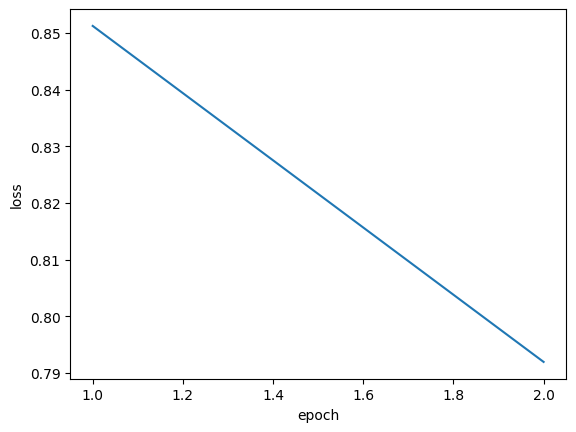

In [ ]:
losses = []
num_epochs = 2

for epoch in range(1, num_epochs + 1):
    model.train()  
    epoch_loss = 0
        
    for train_batch in tqdm(dataloader):
        loss = training_step(model, train_batch, tokenizer.vocab_size, criterion, optimizer, device)
        epoch_loss += loss
        
    avg_epoch_loss = epoch_loss / len(dataloader)
    losses.append(avg_epoch_loss)  
    print(avg_epoch_loss)
    
    plot_losses(losses)

In [ ]:
[model.inference("<bos>") for _ in range(10)]

[264, 60, 98, 111, 115, 62, 265]
torch.Size([1, 6, 64])
torch.Size([1, 6, 266])
torch.Size([1, 266])
13
[264, 60, 98, 111, 115, 62, 265]
torch.Size([1, 6, 64])
torch.Size([1, 6, 266])
torch.Size([1, 266])
11
[264, 60, 98, 111, 115, 62, 265]
torch.Size([1, 6, 64])
torch.Size([1, 6, 266])
torch.Size([1, 266])
82
[264, 60, 98, 111, 115, 62, 265]
torch.Size([1, 6, 64])
torch.Size([1, 6, 266])
torch.Size([1, 266])
53
[264, 60, 98, 111, 115, 62, 265]
torch.Size([1, 6, 64])
torch.Size([1, 6, 266])
torch.Size([1, 266])
100
[264, 60, 98, 111, 115, 62, 265]
torch.Size([1, 6, 64])
torch.Size([1, 6, 266])
torch.Size([1, 266])
75
[264, 60, 98, 111, 115, 62, 265]
torch.Size([1, 6, 64])
torch.Size([1, 6, 266])
torch.Size([1, 266])
3
[264, 60, 98, 111, 115, 62, 265]
torch.Size([1, 6, 64])
torch.Size([1, 6, 266])
torch.Size([1, 266])
47
[264, 60, 98, 111, 115, 62, 265]
torch.Size([1, 6, 64])
torch.Size([1, 6, 266])
torch.Size([1, 266])
16
[264, 60, 98, 111, 115, 62, 265]
torch.Size([1, 6, 64])
torch.Si

['<bos> мгткомѿ?',
 '<bos>т кѿ Ћд',
 '<bos> н Ѓр дехЋѼкоте е ЉаcѺнѲат  ЇЀѲѽ Ѓо уенд? оашнеѴмаде? бт',
 '<bos>нона чооѵ жѻа беѹѲ а ѽ дхы лабѱѻаѻ о',
 '<bos>ЌЅ каЉ кпадо,Ќна пбооЌа боеѽѻонччѽатѾѼоч  кѱ.дн�к ѽае?татѾннѴое  С',
 '<bos>Ан пукорХ аѽеЇ мцвѺттуѾы!оѼй, ЅЇ,ѿднѺо  Ѐоку Їп',
 '<bos>К',
 '<bos>етк ѻ нѽае ЍЋуелн е, ѽаоьашѼоноато',
 '<bos>апов.н па Ї',
 '<bos>ѳѹеќаѴ,Ѵа: тьт б! воЀѴЃЃиералѻт, АЏнан ял  ЋюаѲо.еѻоѻапЀшиѽуе']